In [1]:
import os, sys
from pathlib import Path
import torch
import tifffile as tiff

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

ncomps = 50
model_comps = 500
dr_method = 'PCA'

exp_name="far_bias"

test_path = train_path = macaw_path/exp_name/f'test_hc_data_PCA_{model_comps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{model_comps}'/f'{ncomps}'

In [2]:
import pickle

with open(test_path, 'rb') as f:
    test = pickle.load(f)
    
disease = test['disease']
bias = test['bias']
test_imgs = test['imgs']

encoded_data = test['encoded_data']
pca = test['pca']

img_names = test['img_names']

In [3]:
with open(model_base_path/'hyperparameters.pkl', 'rb') as f:
    hp = pickle.load(f)
    
ncomps= hp['ncomps']
nevecs= hp['nevecs']
nbasecomps= hp['nbasecomps']
ncauses= hp['ncauses']
crop_size= hp['crop_size']

In [4]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def recons(age,bmi,latents, latent_offset=0):
    
    # bmi = scaler_b.inverse_transform(bmi)
    # print(age)
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    # latent_enc = scaler_i.inverse_transform(latent_enc)
    imgs = pca.inverse_transform(latent_enc)
    return age,bmi,imgs

In [5]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

In [6]:
def make_img(x):
    img = (255*x/np.max(x)).reshape(crop_size,crop_size)
    return np.clip(img,0, 255).astype('uint8')

In [7]:
import glob
from PIL import Image

def make_gif(frames, save_name):    
    frames = [Image.fromarray(f) for f in frames]
    frame_one = frames[0]
    return frame_one.save(save_name, format="GIF", append_images=frames, save_all=True, duration=100, loop=0)

In [8]:
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB
from monai.transforms import Compose, ToTensor
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])

/home/volatope/Software/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-06-06 16:20:48.127577: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 16:20:48.128735: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 16:20:48.153972: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow w

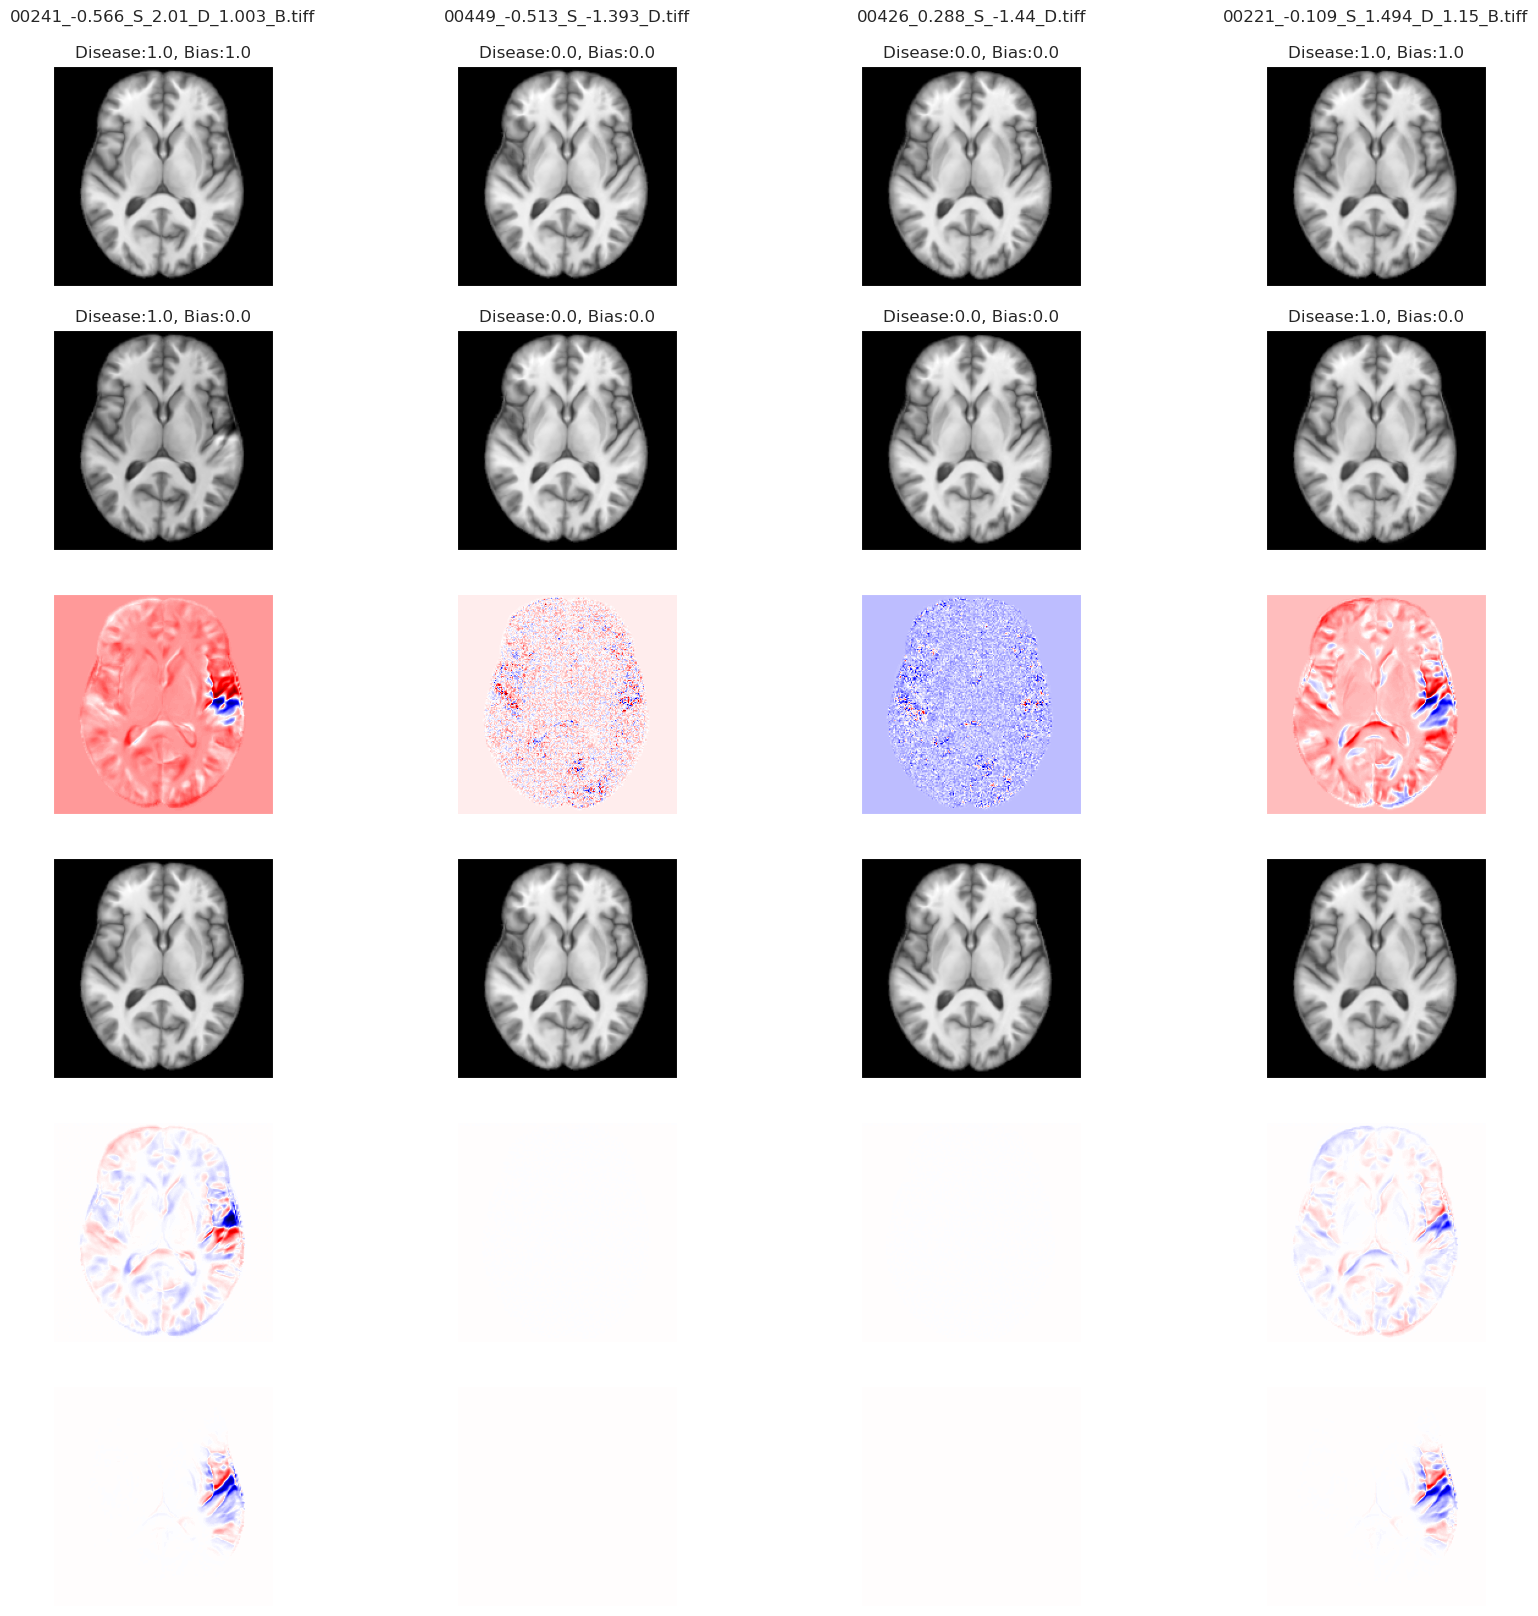

In [20]:
save_name = f'data/{exp_name}/cntr/'
cf_vals = {1:0}
nsamples = 4

rands = np.random.randint(0,encoded_data.shape[0],nsamples)
d_obs = test_imgs[rands,:]
encoded_obs = encoded_data[rands,:]
                                 
names = img_names[rands]

dis_obs = disease[rands]
bias_obs = bias[rands]
residuals = d_obs - pca.inverse_transform(encoded_obs)

cf = np.zeros((nsamples,ncomps))  
for ev in range(0,ncomps-nbasecomps,nevecs-nbasecomps):
    ed =  encoded_obs[:,ev:ev+nevecs]
    X_obs = np.hstack([dis_obs[:,np.newaxis], bias_obs[:,np.newaxis], ed])
    try:
        macaw = torch.load(model_base_path/f'{ev}.pt')
        cc = macaw.counterfactual(X_obs,cf_vals)
    except Exception as e:
        print(e,"Using original")
        cc[:,ncauses:] = X_obs[:,ncauses:].copy()

    cf[:,ev:ev+nevecs] = cc[:,ncauses:]
re_cf = recons(cc[:,0],cc[:,1],cf)
re_cf_resd = re_cf[2] + residuals
# re_cf_resd = re_cf[2]
# 
# d_obs = pca.inverse_transform(encoded_obs)
diff = d_obs - re_cf_resd

fig,axs = plt.subplots(6,nsamples, figsize=(20,20))

for i in range(nsamples):
    axs[0,i].imshow(d_obs[i].reshape(crop_size,crop_size),cmap='gray')
    axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'{names[i]}\n\nDisease:{X_obs[i,0]}, Bias:{X_obs[i,1]}')

    axs[1,i].imshow(make_img(re_cf_resd[i]),cmap='gray')
    axs[1,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Disease:{cc[i,0]}, Bias:{cc[i,1]}')

    axs[2,i].imshow(diff[i].reshape(crop_size,crop_size),cmap='seismic')
    axs[2,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    img = tiff.imread('no_bias/test/'+img_names[rands[i]])
    img = transforms(img).reshape(crop_size,crop_size)
    
    axs[3,i].imshow(img,cmap='gray')
    axs[3,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    # diff between cf no_bias and ground truth no_bias, ideally would have no difference
    axs[4,i].imshow((re_cf_resd[i].reshape(crop_size,crop_size)) - img,cmap='seismic', clim=(-5e-1,5e-1))
    axs[4,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    # shows the bias Emma added
    axs[5,i].imshow(d_obs[i].reshape(crop_size,crop_size) - img,cmap='seismic', clim=(-5e-1,5e-1))
    axs[5,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
if not os.path.exists(save_name):
    os.makedirs(save_name)

plt.savefig(save_name+f"cf1.pdf")
plt.show()

In [10]:
n = rands[0]

In [11]:
fb_img = tiff.imread('far_bias/test/'+ img_names[n])
fb_img = transforms(fb_img).reshape(crop_size,crop_size)

nb_img = tiff.imread('no_bias/test/'+ img_names[n])
nb_img = transforms(nb_img).reshape(crop_size,crop_size)

In [12]:
img_names[n]

'00291_0.893_S_-2.494_D.tiff'

In [13]:
print(disease[n], bias[n])

0 0


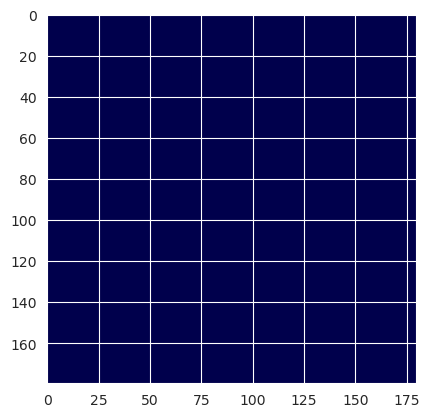

In [14]:
plt.imshow(fb_img-nb_img,cmap='seismic')